# PROJECT-4. Задача классификации
---
---

Импортируем необходимые для работы библиотеки и зависимости:

In [115]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
from termcolor import colored
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import optuna

import warnings
warnings.filterwarnings('ignore')

# Визуальная настройка графиков
sns.set_theme("notebook")
sns.set_palette("tab10")

> Нам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Мы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если мы сможем это сделать, то поднимем доходы банка и поможем понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача как для специалиста в *Data Science*:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов
---

### Условные группы представленных данных:

**Данные о клиентах банка:**

|имя признака|его значение|
|------------|------------|
|`age`|возраст|
|`job`|сфера занятости|
|`marital`|семейное положение|
|`education`|уровень образования|
|`default`|имеется ли просроченный кредит|
|`housing`|имеется ли кредит на жильё|
|`loan`|имеется ли кредит на личные нужды|
|`balance`|баланс|

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

|имя признака|его значение|
|------------|------------|
|`contact`|тип контакта с клиентом|
|`month`|месяц, в котором был последний контакт|
|`day`|день, в который был последний контакт|
|`duration`|продолжительность контакта в секундах|

**Прочие признаки:**

|имя признака|его значение|
|------------|------------|
|`campaign`|количество контактов с этим клиентом в течение текущей кампании|
|`pdays`|количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании|
|`previous`|количество контактов до текущей кампании|
|`poutcome`|результат прошлой маркетинговой кампании|

**Целевая переменная** `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

Читаем предложенный датасет:

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

Исследуем данные на наличие пропусков:

In [3]:
# Отображаем структуру данных.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Выводим основные данные о признаках:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# Исследуем данные на предмет пропусков.
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
# Выодим процент пропусков в признаке balance.
percent = round(df['balance'].isnull().sum() / df.shape[0] * 100, 2)
print(f'Процент пропусков в признаке balance: {percent}.')

Процент пропусков в признаке balance: 0.22.


Дополнительня проверка признака сферы занятости (`job`) на наличие пропусков:

In [7]:
# вывод уникальных значений признака.
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Из представленного массива уникальных значений выделяется значение `unknown`, которое фактически является пропуском.

In [8]:
# Заменяем пропуски в признаке на NaN.
df['job'] = df['job'].apply(lambda x: np.nan if x=='unknown' else x)

In [9]:
# Выодим процент пропусков в признаке job.
percent = round(df['job'].isnull().sum() / df.shape[0] * 100, 2)
print(f'Процент пропусков в признаке job: {percent}.')

Процент пропусков в признаке job: 0.63.


In [10]:
# Проверяем данные на наличие полных дубликатов.
print(f'Количество полных дубликатов данных: {df.duplicated().sum()}.')

Количество полных дубликатов данных: 0.


In [11]:
# Отображаем признак баланса.
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

Также нам необходимо преобразовать значения данного признака к float для дальнейшей работы с ним.

In [12]:
def balance_to_float(balance):
    """вспомогательная функция для преобразования
    баланса клиента к типу данных float.

    Args:
        balance (str): баланс клиента в строковым занчении
    Returns:
        balance (float)
    """
    if balance is not np.nan:
        balance_short = balance.replace(' ', '').replace('$', '').replace(',', '.')
        balance_float = float(balance_short)
        return balance_float
    else:
        pass


# Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(balance_to_float)

Заполняем пропуски в признаке `balance` медианным значением:

In [13]:
# Обрабатываем пропуски в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

Ранее мы выяснили, что в признаке `job` есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Заменим все пропущенные значения в признаке `job` на модальные. То же самое сделаtv с признаком, отвечающим за уровень образования.

In [14]:
# Заменяем пропуски в признаках на NaN.
df['education'] = df['education'].apply(lambda x: np.nan if x=='unknown' else x)

In [15]:
# Обработка пропусков в категориальных признаках: job и education, заменив их на модальные значения
mode_columns = ['education', 'job']
for col in mode_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

Изучение признака `balance` на предмет выбросов:

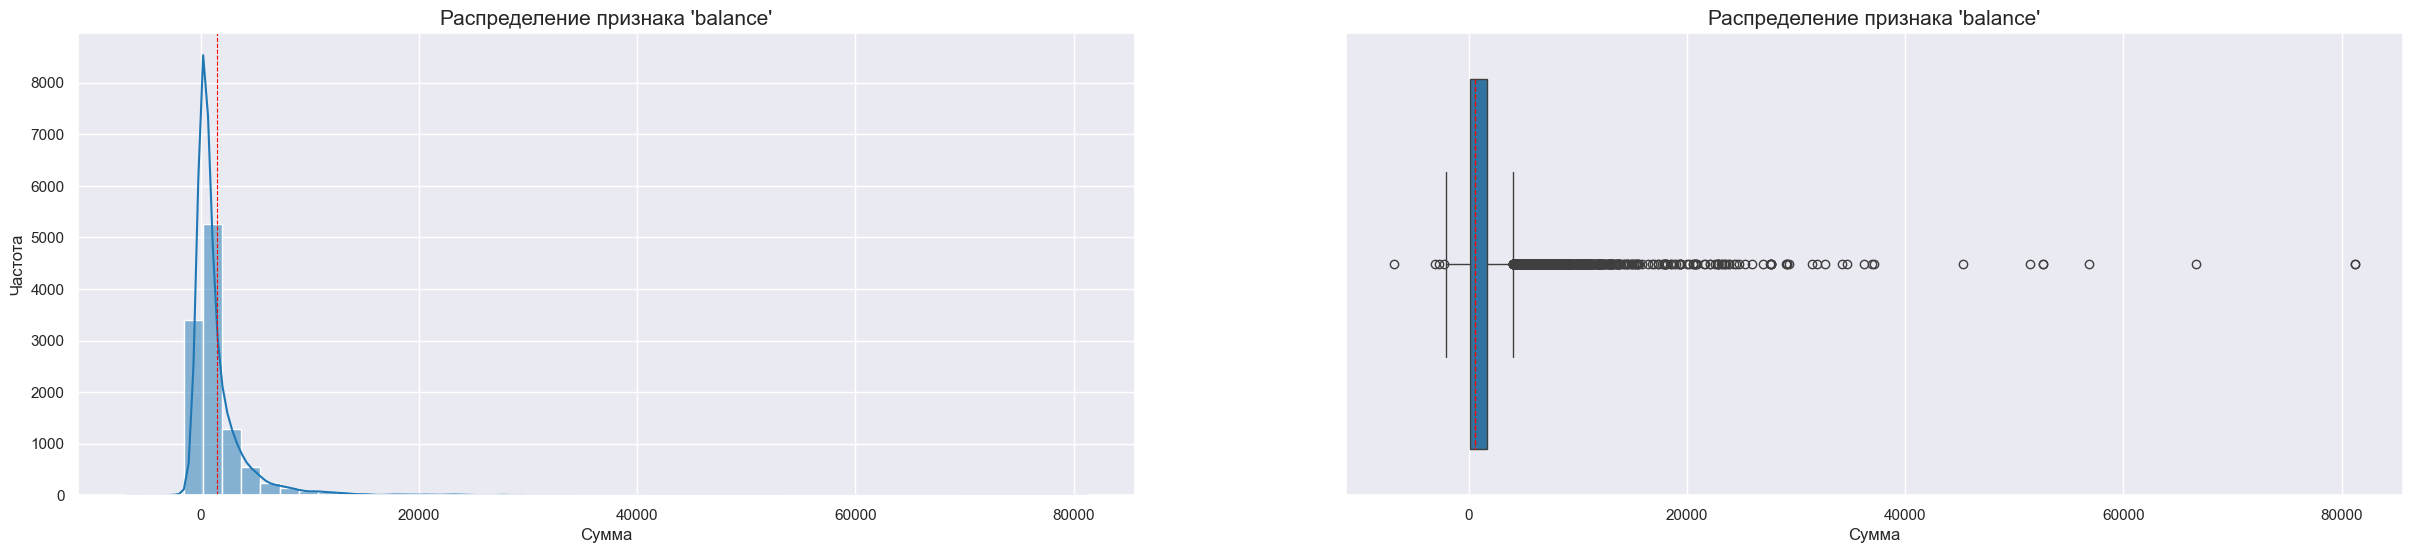

In [16]:
# Осуществляем визуализацию распределения числового признака баланса.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,6))

sns.histplot(data=df['balance'], kde=True, ax=axes[0], bins=50)
axes[0].set_title("Распределение признака 'balance'", fontsize=15)
axes[0].set(xlabel='Сумма', ylabel='Частота')
axes[0].axvline(df['balance'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['balance'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Сумма')
axes[1].set_title("Распределение признака 'balance'", fontsize=15);

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q25 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q75 + 1.5 * IQR$). Найдем эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

In [17]:
# Задаем функцию для поиска выбросов по методу Тьюки.
def outliers_iqr(data, feature):
    """Функция для поиска выбросов по методу Тьюки
    (метод межквартильного размаха)

    Args:
        data (pd.DataFrame): датасет
        feature (str): признак(фактор)

    Returns:
       outliers (pd.DataFrame): датасет, состоящий из выбросов.
       cleaned (pd.DataFrame): датасет без выбросов.
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned


# Определяем выбросы по признаку баланса.
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


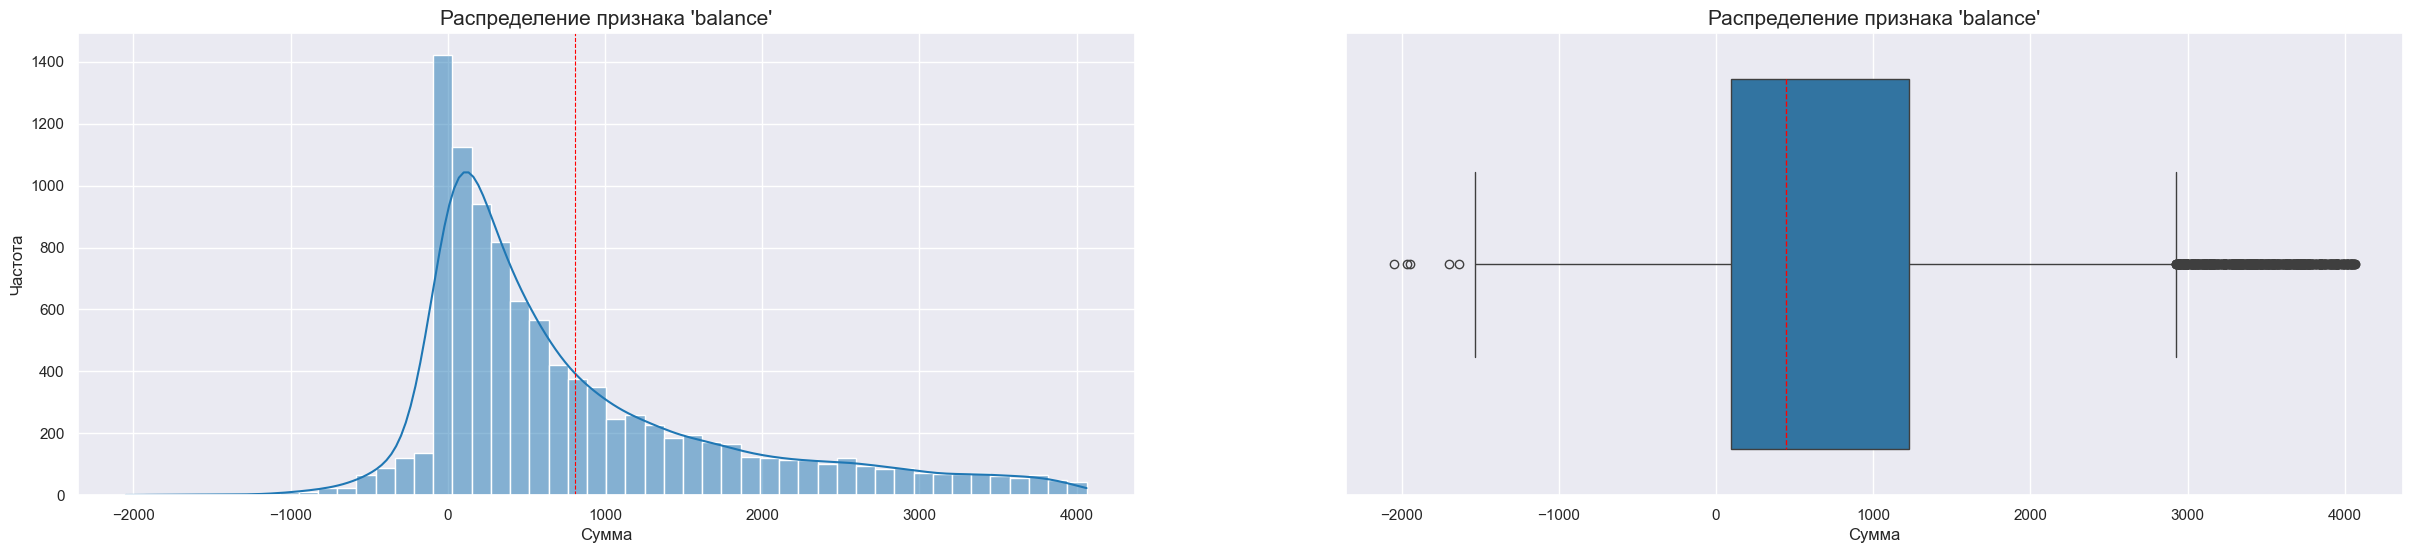

In [18]:
# Проводим повторную визуализацию признака после очистки от выбросов.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,6))

sns.histplot(data=cleaned['balance'], kde=True, ax=axes[0], bins=50)
axes[0].set_title("Распределение признака 'balance'", fontsize=15)
axes[0].set(xlabel='Сумма', ylabel='Частота')
axes[0].axvline(cleaned['balance'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(cleaned['balance'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Сумма')
axes[1].set_title("Распределение признака 'balance'", fontsize=15);

## Часть 2:  Разведывательный анализ
---

### Изучение целевого признака `deposit`:

In [19]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(cleaned['deposit'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), cleaned['deposit'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), cleaned['deposit'].nunique(), sep='\n')

,deposit
count,10105
unique,2
top,no
freq,5424



Тип данных признака:
object

Количество уникальных значений:
2


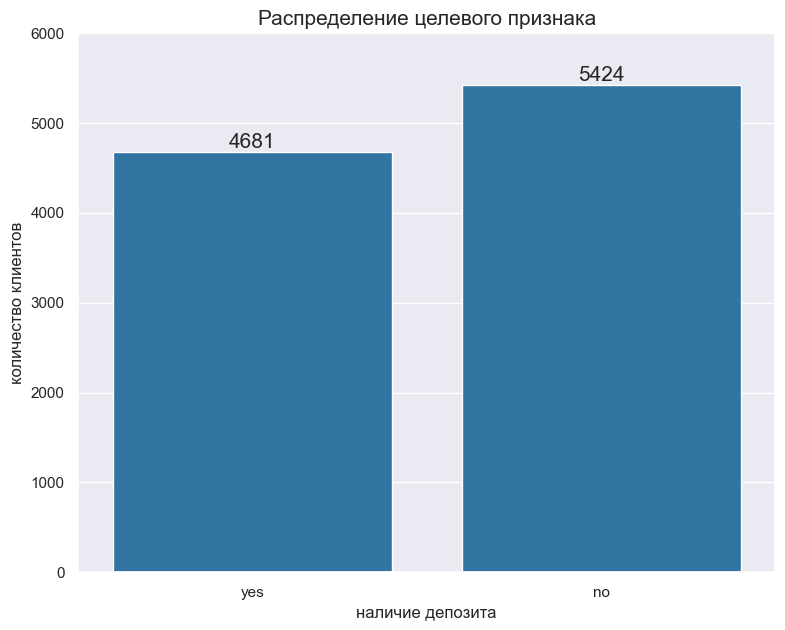

In [20]:
# Визуализация распределения целевого признака. 
fig = plt.figure(figsize=(9,7))

plot = sns.countplot(data=cleaned, x='deposit')
plot.set(xlabel='наличие депозита', ylabel='количество клиентов')
plot.set_title('Распределение целевого признака', fontsize=15)
plot.bar_label(plot.containers[0], fontsize=15)
plt.ylim(0, 6000);

**Выводы по целевому признаку:**  
Признак `deposit` в целом имеет равномерное распределение.

### Общее изучение непрерывных признаков:

In [21]:
# Список непрерывных признаков.
num_cols = list(cleaned.nunique()[cleaned.nunique() > 35].index)

In [22]:
# выводим характеристики для непрерывных признаков.
print(colored('Статистические характеристики непрерывных признаков:', 'green'))
cleaned[num_cols].describe()

Статистические характеристики непрерывных признаков:


,age,balance,duration,pdays
count,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,368.742603,51.319644
std,11.734931,994.151966,346.651524,109.644179
min,18.000000,-2049.000000,2.000000,-1.000000
25%,32.000000,95.000000,137.000000,-1.000000
50%,38.000000,445.000000,252.000000,-1.000000
75%,48.000000,1227.000000,490.000000,2.000000
max,95.000000,4063.000000,3881.000000,854.000000


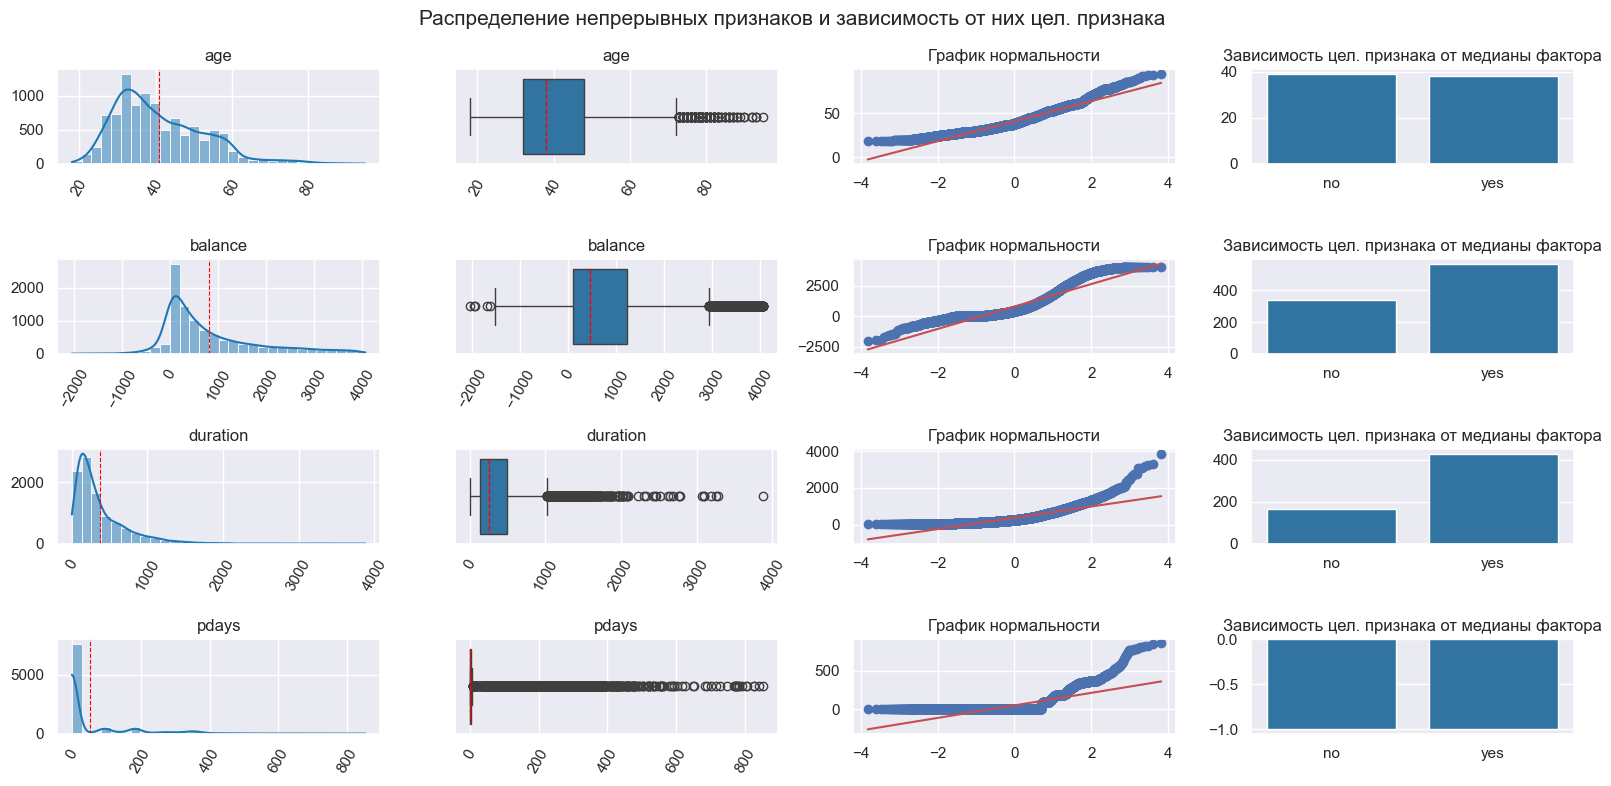

In [23]:
# Визуализация непрерывных признаков.
n = len(num_cols)
fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(16,8))
for i, feature in enumerate(num_cols):
    sns.histplot(cleaned[feature], kde=True, ax=axes[i,0], bins=30)
    axes[i,0].set_title(feature, fontsize=12)
    axes[i,0].set(xlabel='', ylabel='')
    axes[i,0].axvline(cleaned[feature].mean(), color='red', linestyle='--', linewidth=0.8)
    axes[i,0].xaxis.set_tick_params(rotation=60)
    
    sns.boxplot(cleaned[feature], ax=axes[i,1], orient='h', medianprops={"color": "red", "linestyle": '--'})
    axes[i,1].set(xlabel='', ylabel='')
    axes[i,1].set_title(feature, fontsize=12)
    axes[i,1].xaxis.set_tick_params(rotation=60)
    
    stats.probplot(cleaned[feature], plot=axes[i,2])
    axes[i,2].set(xlabel='', ylabel='')
    axes[i,2].set_title('График нормальности', fontsize=12)
    
    sns.barplot(cleaned.groupby('deposit')[feature].median(), ax=axes[i,3])
    axes[i,3].set(xlabel='', ylabel='')
    axes[i,3].set_title(f"Зависимость цел. признака от медианы фактора", fontsize=12)
plt.suptitle('Распределение непрерывных признаков и зависимость от них цел. признака', fontsize=15)
plt.tight_layout()

**Предварительные выводы по разведывательному анализу непрерывных признаков:**  
1. Клиенты банка в большинтсве своем находятся в возрастной группе от 35 до 50. При этом фактор возраста никак не влияет на наличие или отсуствие депозита у клиента.

2. Большинство клиентов банка имеют баланс от 0 до 1 000. Данный фактор влияет на наличие депозита у клиента.

3. Продолжительность контакта в секундах с большинством клиентов составляет до 4 минут, при этом данный фактор сильно влияет на наличие депозита у клиента. 

### Общее изучение категориальных признаков:

In [24]:
# Список категориальных признаков.
cat_cols = list(cleaned.nunique()[cleaned.nunique() <= 35].index)
cat_cols.remove('deposit')

In [25]:
# Выводим характеристики для категориальных признаков.
print(colored('Статистические характеристики категориальных признаков:', 'green'))
cleaned[cat_cols].describe(include='all')

Статистические характеристики категориальных признаков:


,job,marital,education,default,housing,loan,contact,day,month,campaign,previous,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105.000000,10105,10105.000000,10105.000000,10105
unique,11,3,3,2,2,2,3,NaN,12,NaN,NaN,4
top,management,married,secondary,no,no,no,cellular,NaN,may,NaN,NaN,unknown
freq,2315,5715,5517,9939,5243,8712,7283,NaN,2617,NaN,NaN,7570
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.590302,NaN,2.517170,0.816230,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.441510,NaN,2.707159,2.243795,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,1.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,2.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,3.000000,1.000000,NaN


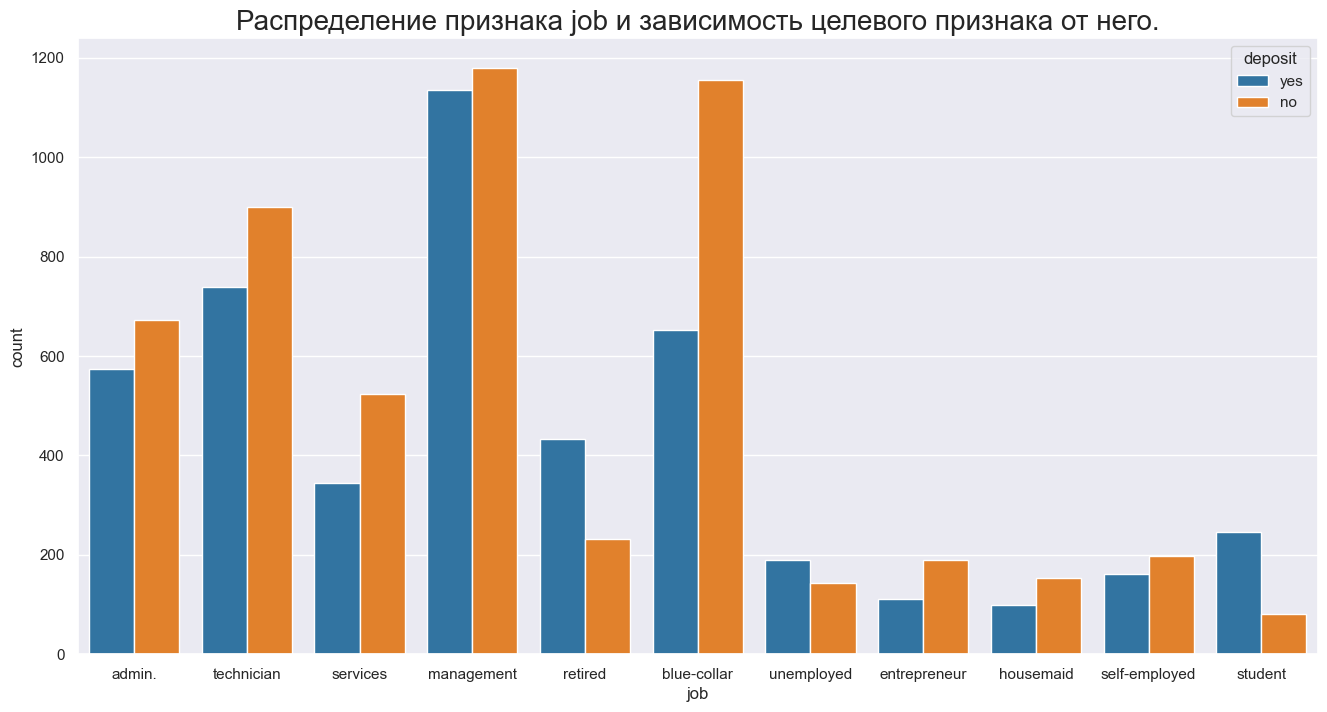

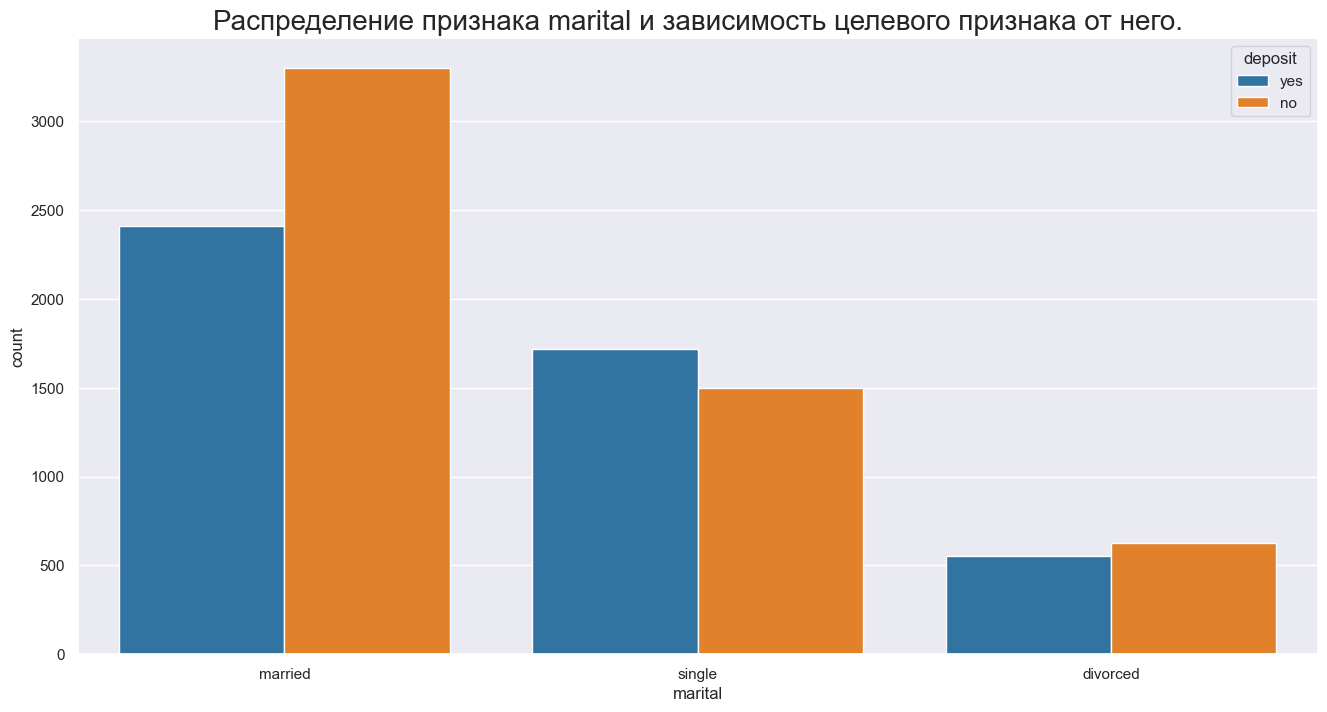

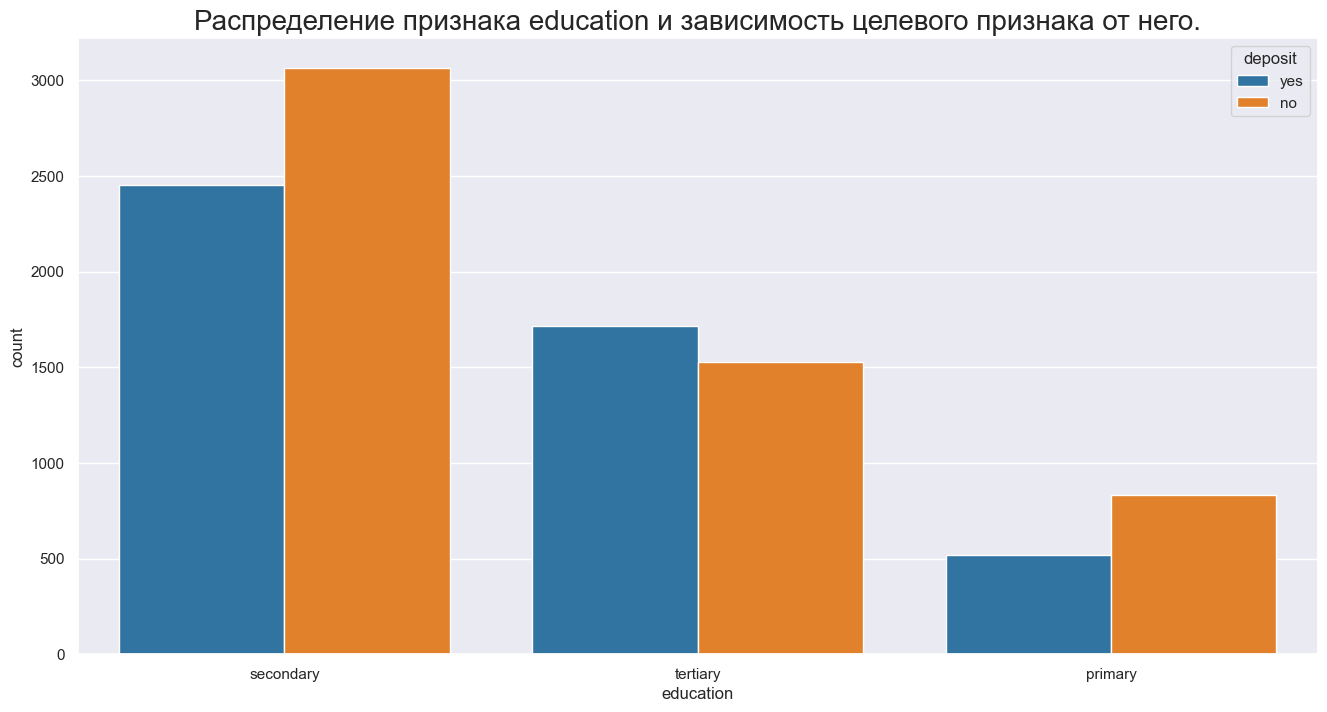

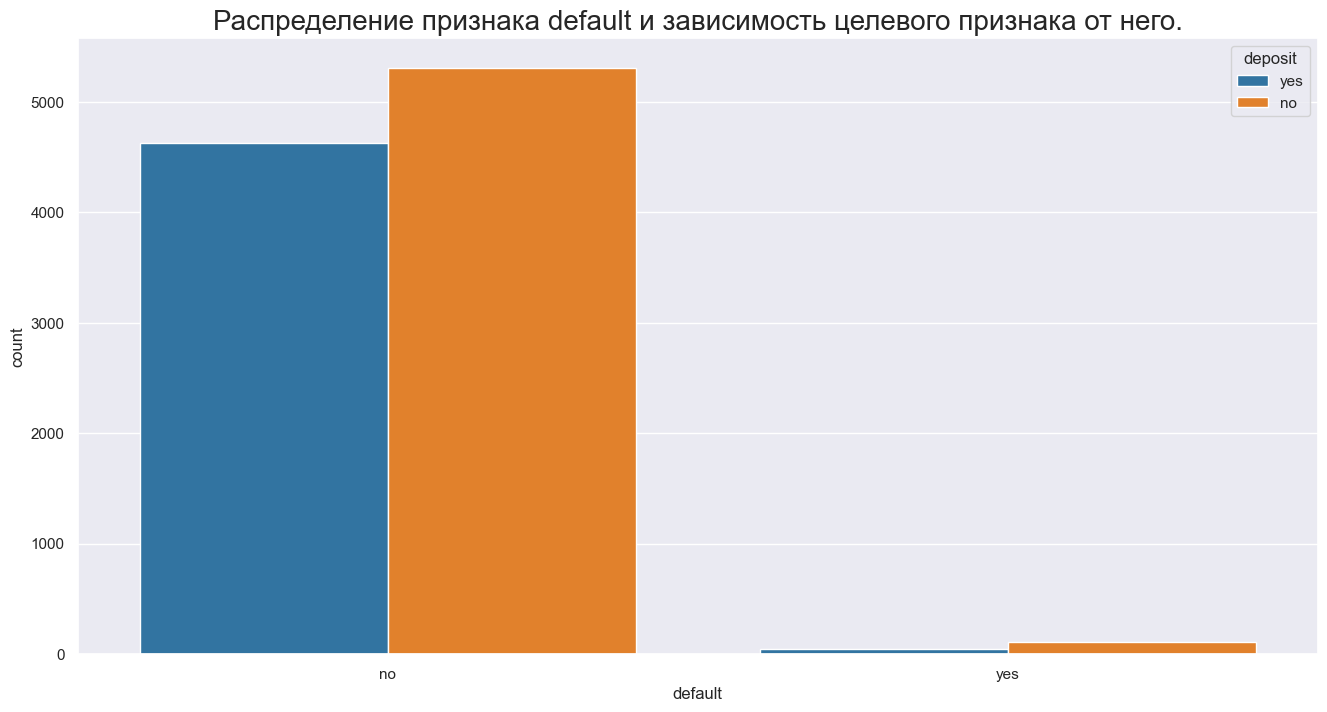

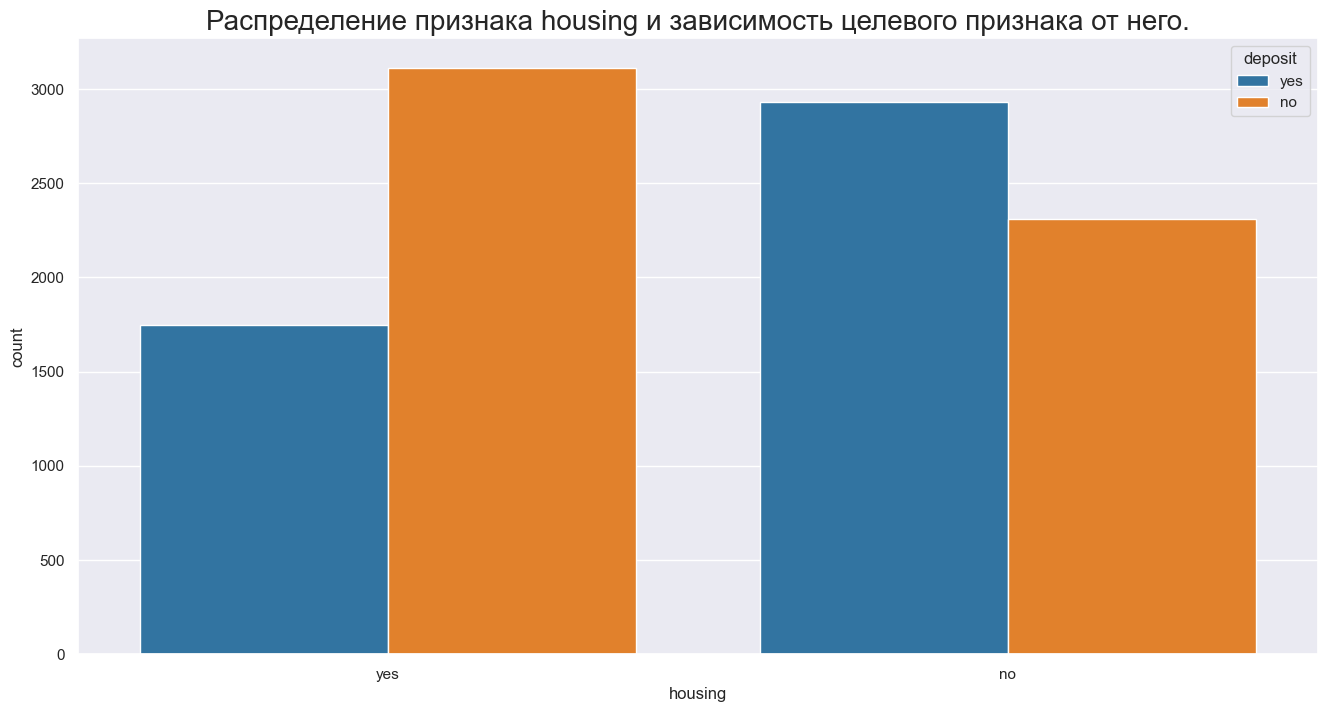

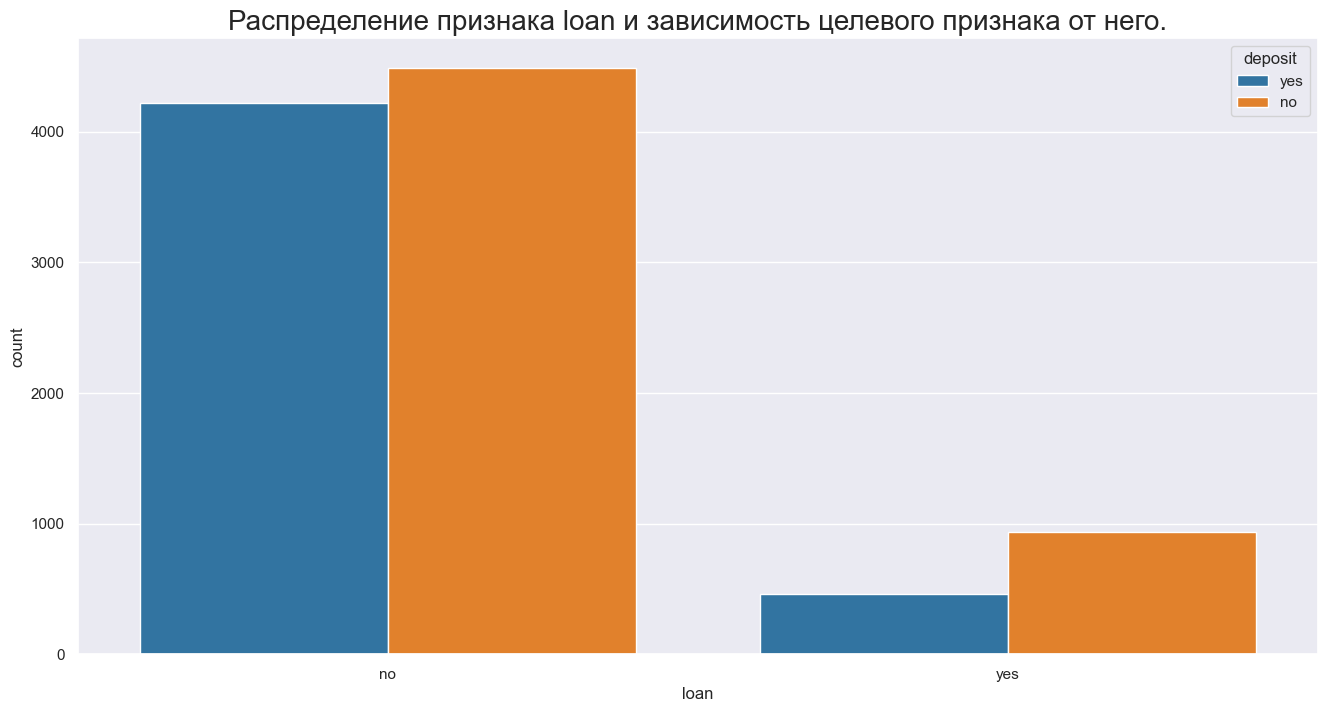

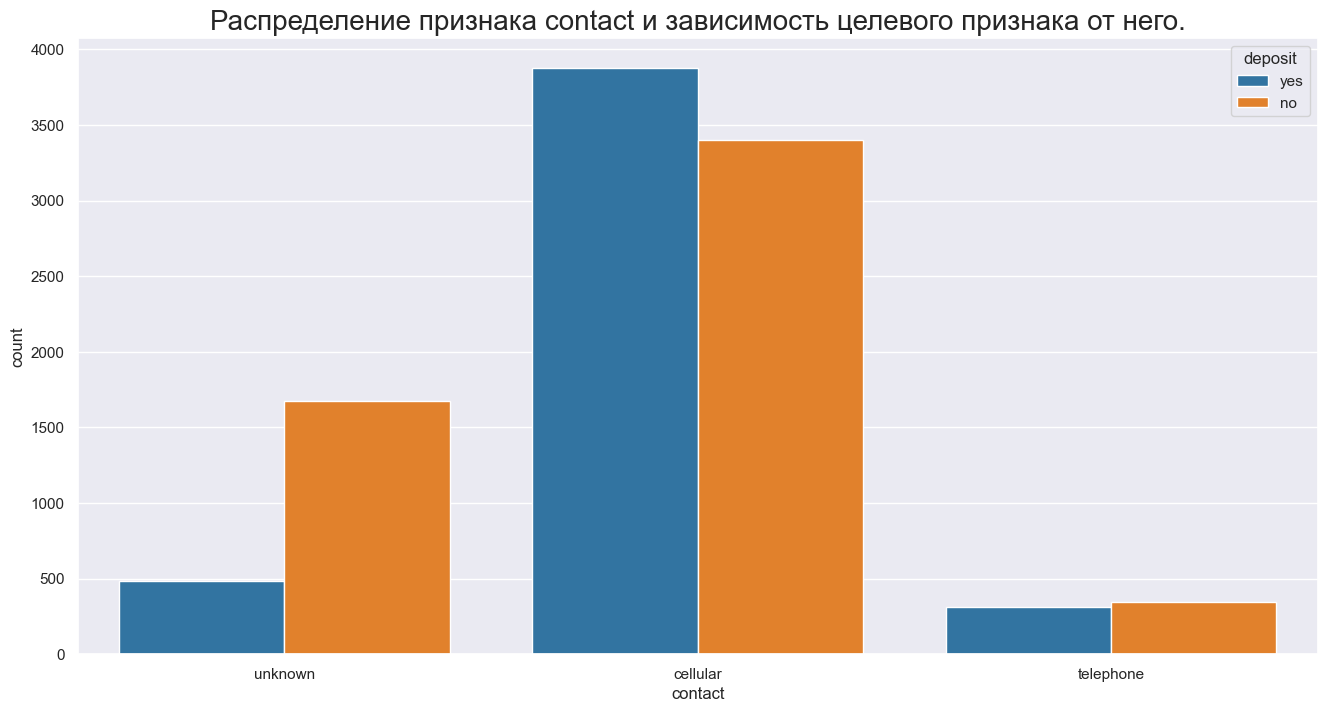

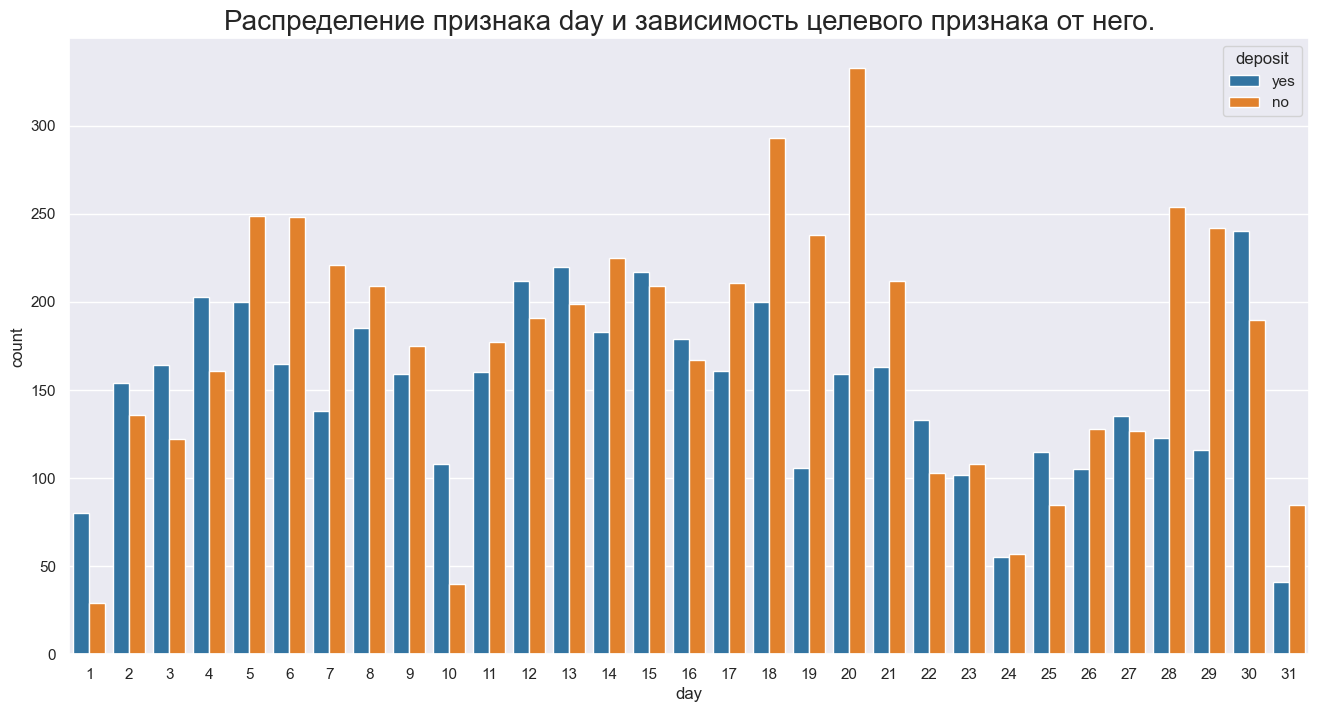

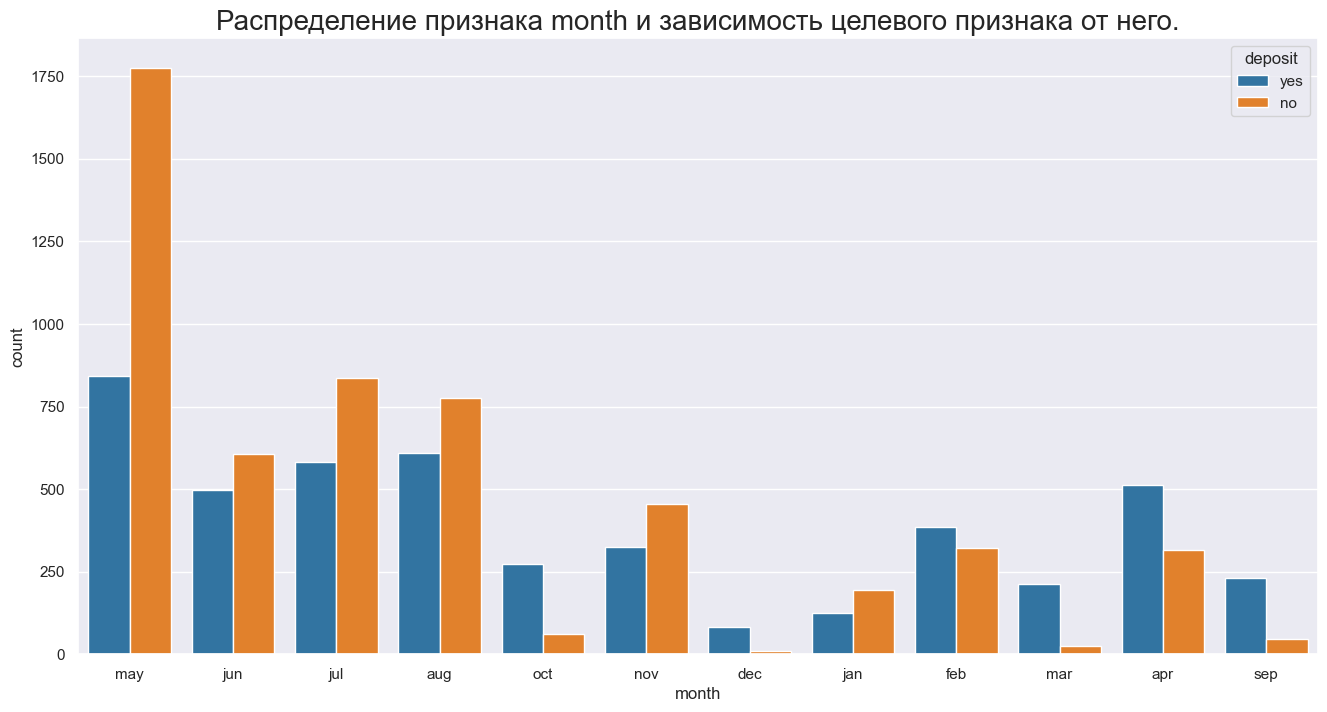

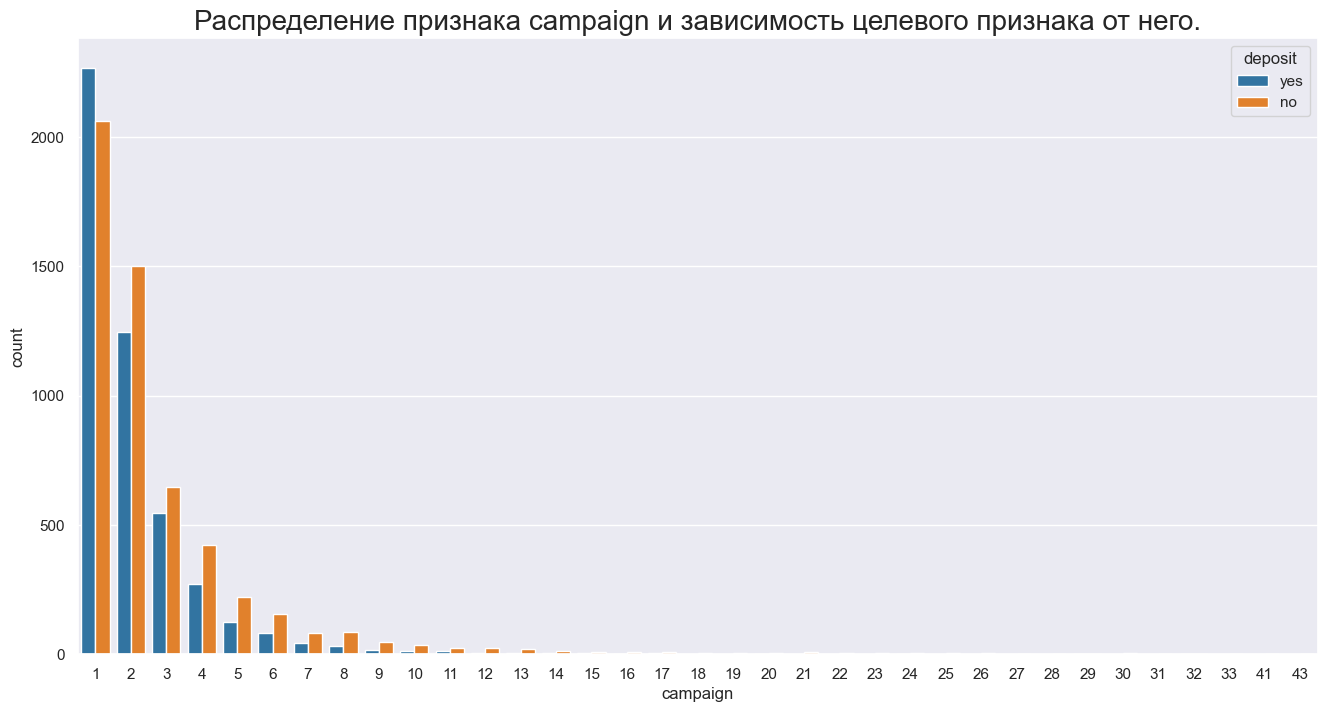

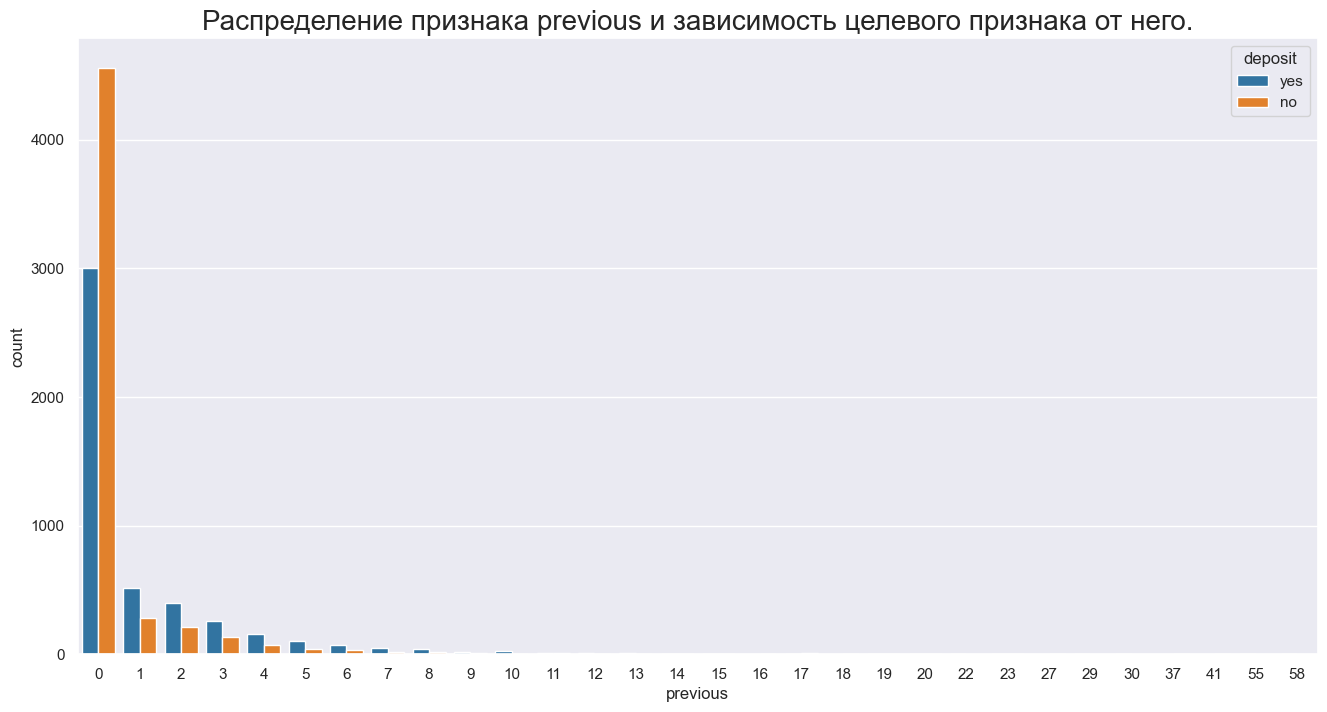

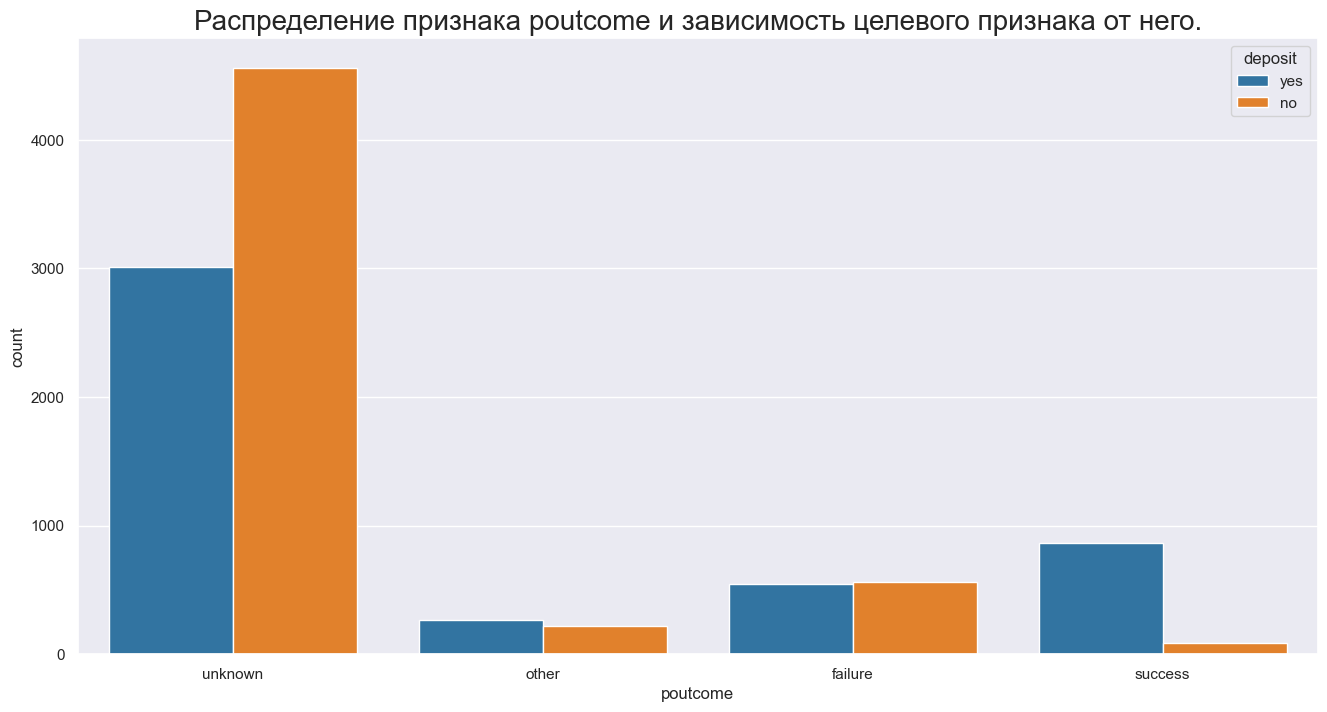

In [26]:
# Визуализация категориальных признаков.
for i, feature in enumerate(cat_cols):
    fig = plt.figure(figsize=(16,8))
    sns.countplot(data=cleaned, x=feature, hue='deposit')
    plt.title(f'Распределение признака {feature} и зависимость целевого признака от него.', fontsize=20)

Для более нагядного анализа возрастных групп клиентов целесообразно разделить их на условные 5 групп:

- `'<30'`;

- `'30-40'`;

- `'40-50'`;

- `'50-60'`;

- `'60+'`.

In [27]:
# Задаем функцию для определения возрастной категории.
def age_category(age):
    """вспомогательная функция для категорирования
    непрерывного признака возраста клиентов.

    Args:
        age (int): возраст клиента
    
    Returns:
        age (object): категория возраста
    """
    if age < 30:
        return '<30'
    elif age>=30 and age<40:
        return '30-40'
    elif age>=40 and age<50:
        return '40-50'
    elif age>=50 and age<60:
        return '50-60'
    else:
        return '60+'

# Применяем вспомогательную функцию.
cleaned['age'] = cleaned['age'].apply(age_category)

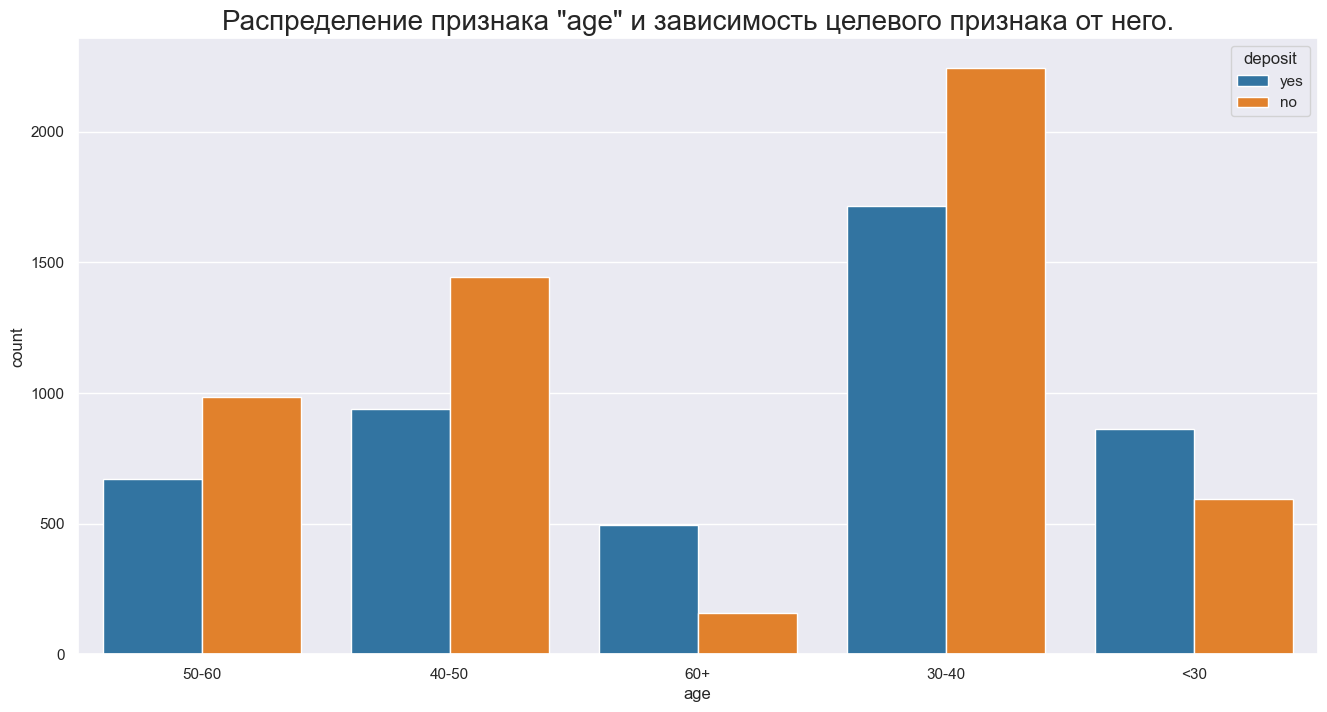

In [28]:
# Визуализация клиентов по возрасту и депозитным предпочтениям.
fig = plt.figure(figsize=(16,8))
sns.countplot(data=cleaned, x='age', hue='deposit')
plt.title(f'Распределение признака "age" и зависимость целевого признака от него.', fontsize=20);

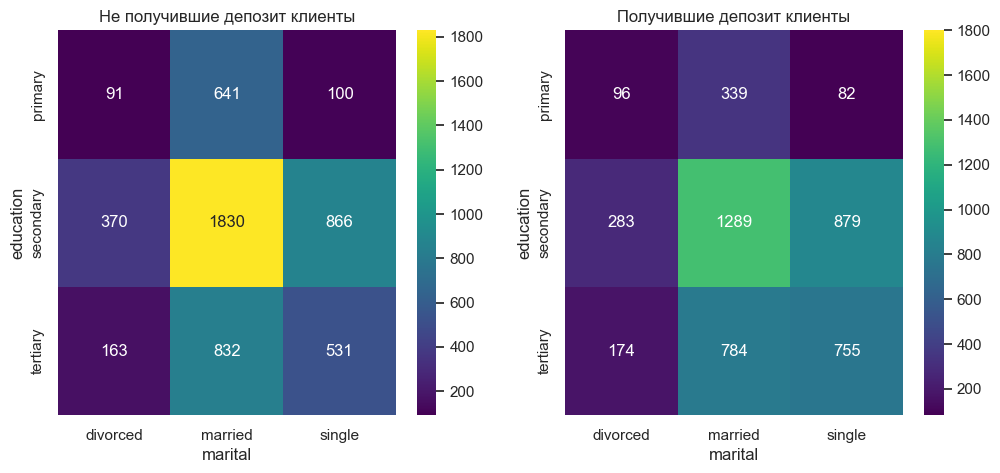

In [29]:
# Задаем датасеты для анализа.
pivot_data_1 = pd.pivot_table(
    data=cleaned[cleaned['deposit']=='yes'],
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'
)

pivot_data_0 = pd.pivot_table(
    data=cleaned[cleaned['deposit']=='no'],
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'
)

# Визуализируем распределение по признакам семейного положения и образования.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.heatmap(pivot_data_0, annot=True, fmt='.5g', cmap='viridis', ax=axes[0])
sns.heatmap(pivot_data_1, annot=True, fmt='.5g', cmap='viridis', vmax=1800, ax=axes[1])
axes[0].set_title('Не получившие депозит клиенты')
axes[1].set_title('Получившие депозит клиенты');

**Предварительные выводы по разведывательному категориальных признаков:**  
1. Клиенты банка из числа пенсионеров, студентов (они же в возрастных категориях 60+ и <30 соответственно) и безработных более склонны к оформлению депозитов. В то же время клиенты из числа рабочих (т.н. синие воротнички) более склонны к отказу от депозита в своем срезе. Также, отмечается, что несмотря на равенство акцепта и отказа от депозита в среде клиентов из сферы менеджмента - данные клиенты составляют наибольший процент акцепта депозита.

2. Подавляющая часть клиентов не имеет просрочек по кредитным обязательствам.

3. Наибольшее количество отказов в оформлении депозитов наблюдается в 5-х и 20-х числах каждого месяца (что, скорее всего, обусловлено датами получения зароботной платы и аванса). Лучшие месяцы для предложения депозита клиенту: с февраля по апрель включительно, а также сентябрь и октябрь.

4. Если после первого контакта клиент не соглашается на депозит, то последующие контаткты с ним в рамках одной компании не целесообразны ввиду доминирования процента отказа от него.

5. Те клиенты, кто ранее соглашался на депозит, с большой долей вероятности оформят его снова.

6. Наибольшее количество клиентов банка находятся в браке и имеют второе высшее образование.

## Часть 3: Преобразование данных
---

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: `education`. По аналогии закодируем признак возраста.

In [30]:
# Преобразование уровней образования и возраст.
encoder = LabelEncoder()

ordinal_cols = ['education', 'age']

for feature in ordinal_cols:
    cleaned[feature] = encoder.fit_transform(cleaned[feature])

Перекодируем переменную `deposit` таким образом, чтобы вместо *yes* она принимала значение 1, а вместо *no* — 0. Аналогичное кодирование применим к прочим бинарным признакам.

In [31]:
# Преобразование целевого признака и прочих бинарных признаков.
bin_cols = ['deposit', 'default', 'housing', 'loan']
for feature in bin_cols:
    cleaned[feature] = cleaned[feature].apply(lambda x: 1 if x=='yes' else 0)

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

- `job`;
- `marital`;
- `contact`;
- `month`;
- `poutcome`.

In [32]:
# Преобразуем дамми-переменные.
columns_to_ohe = ['job', 'marital', 'contact', 'month', 'poutcome']
cleaned_dummies = pd.get_dummies(cleaned, columns=columns_to_ohe)

Альтернативный вариант кодирования:

In [33]:
# # Cоздаем дамми-переменные.
# ohe_encoder = preprocessing.OneHotEncoder()
# ohe_data = ohe_encoder.fit_transform(cleaned[columns_to_ohe]).toarray()
# ohe_col_names = ohe_encoder.get_feature_names_out(columns_to_ohe)

# ohe_data = pd.DataFrame(ohe_data, index=cleaned.index, columns=ohe_col_names)
# cleaned = pd.concat([cleaned, ohe_data], axis=1)
# cleaned.drop(columns_to_ohe, axis=1, inplace=True)

Для оценки мультколлинеарности факторов пострим матрицу корреляции:

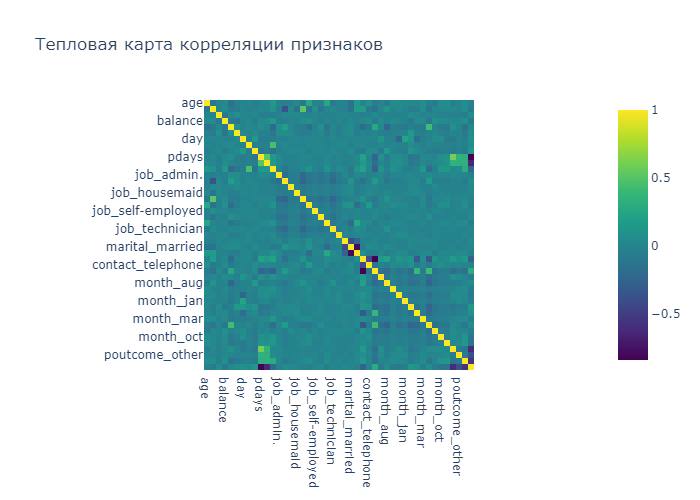

In [34]:
# Новая переменная для производного датасета.
data_corr = cleaned_dummies

# Построение интерактивной тепловой карты (для наглядности: много факторов).
fig = px.imshow(data_corr.corr(), 
                text_auto=True, 
                color_continuous_scale='viridis', 
                title='Тепловая карта корреляции признаков'
                )

# Визуализация.
fig.show('png') # для интерактивного просмотра - убрать параметр 'png'

Для вычленения отдельной степени корреляции каждого фактора с целевой переменной построим столбчатую диаграмму.

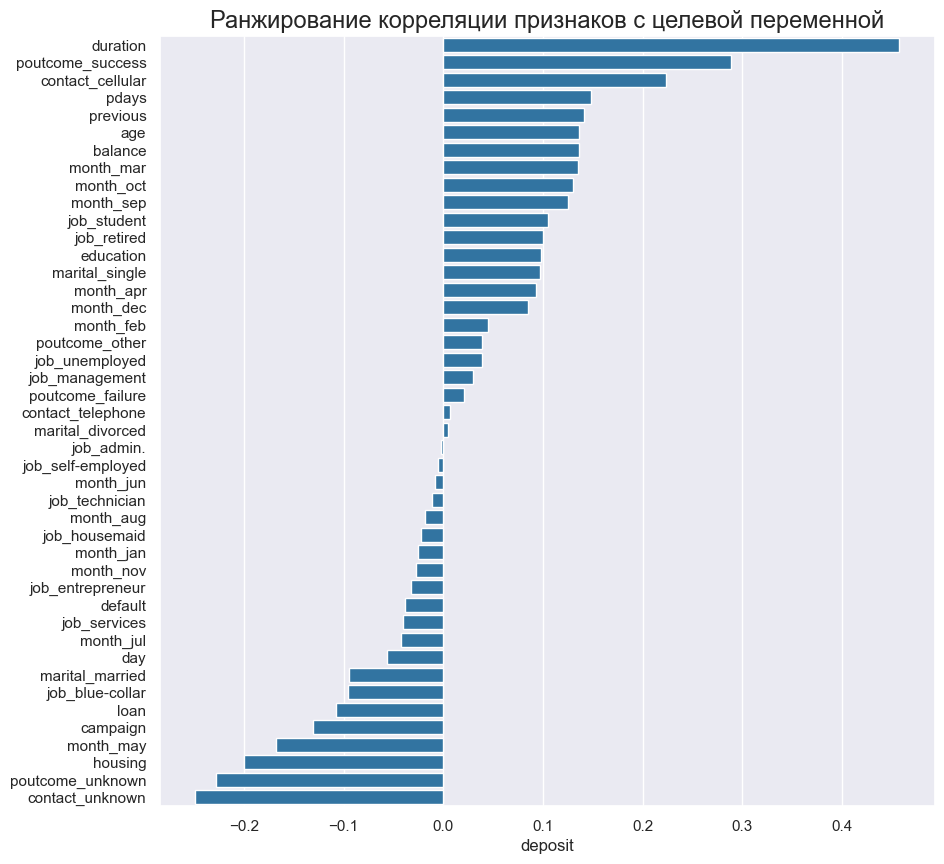

In [35]:
# Производный датасет для диаграммы.
barplot_data = data_corr.corr().loc['deposit'].sort_values(ascending=False).drop('deposit')

# Визуализация диаграммы.
plt.figure(figsize=(10,10))
sns.barplot(barplot_data, orient='h')
plt.title('Ранжирование корреляции признаков с целевой переменной', fontsize=17);

In [36]:
# Задаем функцию для поиска мультиколлинеарных признаков.
def multicorr_check(data, method='pearson', corr_level=0.75):
    """Производная функция для проверки мультиколлинеарности,
    которая выводит данные зависимости в виде текста.

    Args:
        data (pd.DataFrame): датафрейм.
        method (str): метод оценки корреляции ('pearson'-def, 'spearman', 'kendall')
        corr_level (float): модуль уровеня для мультиколлинеарности (по умолчанию 0,75)
    """
    data = data.corr(method=method, numeric_only=True)
    multi_dict = defaultdict(list)
    for col in data.columns:
        for index in data.index:
            if index != col:
                if data.loc[index, col] <= -corr_level or data.loc[index, col] >= corr_level:
                    if index not in multi_dict[col]:
                        multi_dict[col].append(index)
                    else:
                        pass
    for col in multi_dict:
        print (f'Факторы {multi_dict[col]} мультиколлениарны с фактором {col}.')          
    if not multi_dict:
        print('Мультиколлинеарные признаки отсутствуют.') 


# Применяем нашу функцию к датасету.
multicorr_check(data_corr, corr_level=0.9)

Мультиколлинеарные признаки отсутствуют.


Определяем целевую переменную и предикторы, а также разделяем выборку на обучающую и тестовую.

In [37]:
# Задаем матрицу наблюдений и вектор ответов.
X = cleaned_dummies.drop(['deposit'], axis=1)
y = cleaned_dummies['deposit']

# Осуществляем hold-out (отложенную) двойную выборку. 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью `SelectKBest` отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр `score_func = f_classif`.

In [38]:
# С помощью SelectKBest отберем признаки.
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
strong_feats = list(selector.get_feature_names_out())
 
print('15 наиболее сильных признаков: ', strong_feats)

15 наиболее сильных признаков:  ['age', 'balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать *min-max*-нормализацию.

In [39]:
# Нормализация с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()

# Преобразуем данные и ограничиваем выборку сильными признаками.
mm_scaler.fit(X_train[strong_feats])
X_train_scaled = mm_scaler.transform(X_train[strong_feats])
X_test_scaled = mm_scaler.transform(X_test[strong_feats])

# Приводим к виду фреймов.
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train[strong_feats].index, columns=X_train[strong_feats].columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test[strong_feats].index, columns=X_test[strong_feats].columns)

## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья
---

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать `'sag'`, в качестве значения параметра `random_state` возьмём число 42 и запустим 1000 итераций.

In [60]:
# Задаем модель логистической регресии.
lr_model = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
lr_model.fit(X_train_scaled, y_train)
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики логистической регрессии:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики логистической регрессии: 

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Простой алгоритм обучен. Теперь обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

- `criterion = 'entropy'`;

- `random_state = 42`.

In [59]:
# Задаем модель дерева решений.
dt_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    random_state=42
)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
dt_model.fit(X_train_scaled, y_train)
y_train_pred = dt_model.predict(X_train_scaled)
y_test_pred = dt_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики дерева решений для классификации:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики дерева решений для классификации: 

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Осуществим оптимизацию гиперпараметров модели посредством метода *GridSearch*:

In [42]:
# Задаем сетку параметров.
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]}

# Вызываем оптимизатор.
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid
)

# Обучаем оптимизатор (запускаем кросс-валидацию) и делаем предсказание.
grid_search.fit(X_train_scaled, y_train)
y_test_pred = grid_search.predict(X_test_scaled)

# Выводим лучшие параметры и метрику.
print(f'Лучшие параметры модели: {grid_search.best_params_}.',
      f'Метрика accuracy модели на тестовой выборке: {round(grid_search.score(X_test_scaled, y_test),2)}.', 
      f'Метрика f1_score на тестовой выборке: {round(metrics.f1_score(y_test, y_test_pred),2)}', sep='\n')

Лучшие параметры модели: {'max_depth': 7, 'min_samples_split': 7}.
Метрика accuracy модели на тестовой выборке: 0.82.
Метрика f1_score на тестовой выборке: 0.81


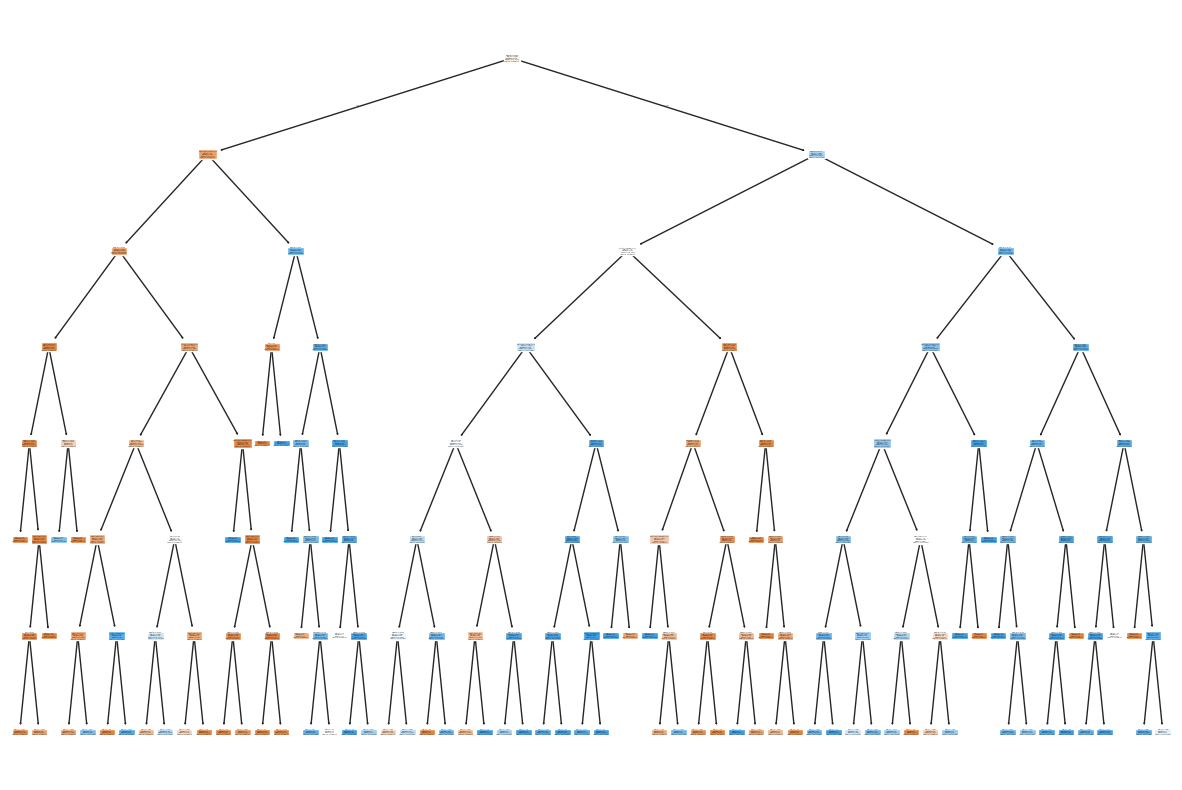

In [43]:
# Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
# Строим граф дерева решений с подобранными гиперпараметрами.
tree_graph = tree.plot_tree(
    grid_search.best_estimator_,
    feature_names=X_test_scaled.columns,
    class_names=["0 - Not deposit", "1 - With deposit"],
    filled=True
);

## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза
---

Для улучшения метрик классификации применим беггинг в виде случайного леса.

In [58]:
# Задаем модель случайного леса.
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
rf_model.fit(X_train_scaled, y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики случайного леса для классификации:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики случайного леса для классификации: 

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Для потенциального улучшения результатов классификации и для сравнения моделей используем градиентный бустинг для классификации.

In [57]:
# Задаем модель градиентного бустинга.
gb_model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
gb_model.fit(X_train_scaled, y_train)
y_train_pred = gb_model.predict(X_train_scaled)
y_test_pred = gb_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики градиентного бустинга для классификации:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики градиентного бустинга для классификации: 

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Теперь мы будем использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

In [56]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [('dt', dt_model), ('lr', lr_model), ('gb', gb_model)]

# Инициируем стекинг-модель.
stack_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=lr_model
)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
stack_model.fit(X_train_scaled, y_train)
y_train_pred = stack_model.predict(X_train_scaled)
y_test_pred = stack_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики стекинга для классификации:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики стекинга для классификации: 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, выберем три признака, дающих наибольший вклад.

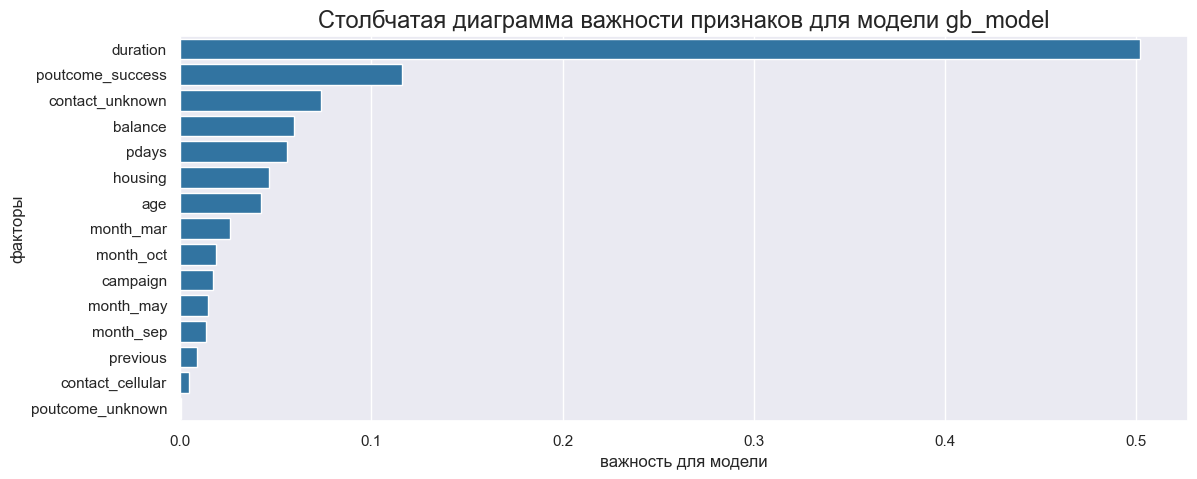

In [91]:
# Визуализация значимости признаков для модели градиентного бустинга.
importances_data = pd.Series(gb_model.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(importances_data, orient='h',ax=ax)
ax.set_title('Столбчатая диаграмма важности признаков для модели gb_model', fontsize=17)
ax.set_xlabel('важность для модели')
ax.set_ylabel('факторы');

**Выводы из графика:**  
Как мы видим из вышеуказанной диаграммы наиболее важными для модели `gb_model` факторами оказались `duration` и `poutcome_success`, что очевидно, т.к. чем больше продолжительность контакта во время компании с клиентом, тем выше вероятность, что он оформит депозит. Также верно то, если клиент во время прошлой компании оформил депозит, то и в рамках новой компании он поступит так же.

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи *GridSearch*. Однако это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк *Optuna*. Применим его для оптимизации гиперпараметров.

In [100]:
# Задаем функцию для оптимизации.
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [101]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=15)

[I 2024-09-18 20:53:48,153] A new study created in memory with name: RandomForestClassifier
[I 2024-09-18 20:53:49,156] Trial 0 finished with value: 0.8930131004366813 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.8930131004366813.
[I 2024-09-18 20:53:49,892] Trial 1 finished with value: 0.8508717310087173 and parameters: {'n_estimators': 128, 'max_depth': 24, 'min_samples_leaf': 9, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8930131004366813.
[I 2024-09-18 20:53:50,672] Trial 2 finished with value: 0.9231974921630094 and parameters: {'n_estimators': 103, 'max_depth': 24, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 2 with value: 0.9231974921630094.
[I 2024-09-18 20:53:51,622] Trial 3 finished with value: 0.9227642276422764 and parameters: {'n_estimators': 128, 'max_depth': 26, 'min_samples_leaf': 2, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.9231974921630094.
[

CPU times: total: 12.7 s
Wall time: 13.4 s


In [102]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 103, 'max_depth': 24, 'min_samples_leaf': 2, 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.92


In [112]:
# Задаем модель случайного леса c полученными параметрами.
best_rf_model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)

# Обучаем модель и делаем предсказания для тренировочной и тестовой выборок.
best_rf_model.fit(X_train_scaled, y_train)
y_train_pred = best_rf_model.predict(X_train_scaled)
y_test_pred = best_rf_model.predict(X_test_scaled)

# Отображаем основные метрики классификации.
print(colored('Метрики случайного леса + optuna для классификации:', 'green'), '\n')
print(metrics.classification_report(y_train, y_train_pred))
print('-'*54, '\n')
print(metrics.classification_report(y_test, y_test_pred))

Метрики случайного леса + optuna для классификации: 

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3634
           1       0.91      0.94      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Проведем ряд полезных визуализаций подбора гиперпараметров посредством фреймворка *Optuna*:

График истории оптимизации - отображает количество испытаний на оси $x$ и метрику на оси $y$:

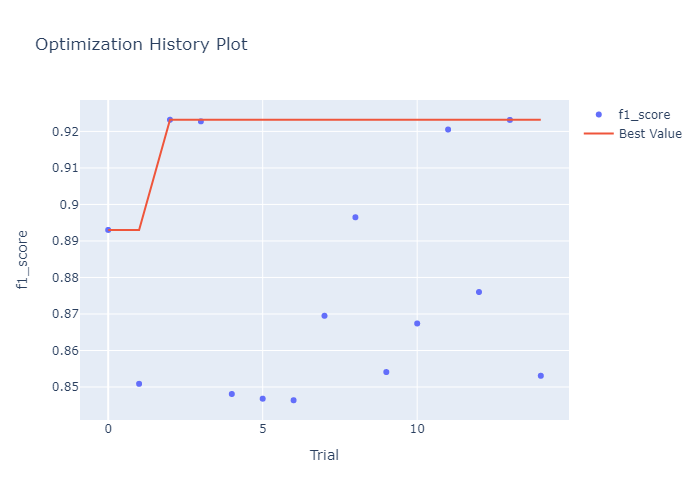

In [106]:
fig = optuna.visualization.plot_optimization_history(study, target_name="f1_score")
fig.show('png') # для интерактивного отображения - убрать параметр 'png'

**Вывод по графику:**  
В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров:

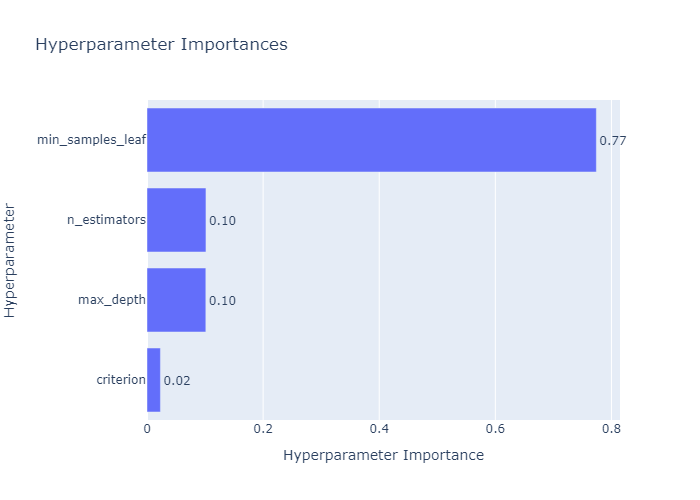

In [107]:
fig = optuna.visualization.plot_param_importances(study, target_name="f1_score")
fig.show('png') # для интерактивного отображения - убрать параметр 'png'

**Вывод по графику:**  
Стоит обратить большее внимание на настройку гиперпараметра `min_samples_leaf`.

График контура отношений гиперпараметров (на параметрах `max_depth` и `n_estimators`):

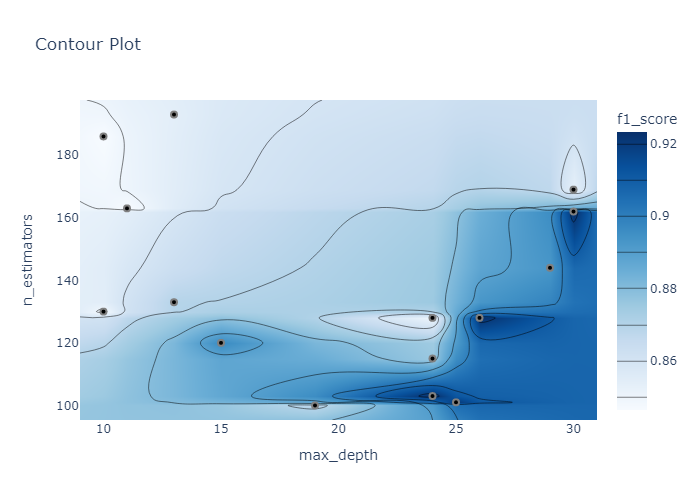

In [111]:
fig = optuna.visualization.plot_contour(study, 
                                        params=["max_depth", "n_estimators"],
                                        target_name="f1_score")
fig.show('png') # для интерактивного отображения - убрать параметр 'png'

### Сводная таблица результатов метрик построенных моделей:

|тип модели|precision|recall|f1-score|
|----------|----------|------|--------|
|<spam style='color:red'>*логистическая регрессия*</spam>|<spam style='color:red'>0.83</spam>|<spam style='color:red'>0.73</spam>|<spam style='color:red'>0.78</spam>|
|*дерево решений*|0.79|0.82|0.81|
|*случайный лес*|0.80|0.83|0.82|
|*градиентный бустинг*|0.80|0.83|0.82|
|*стекинг*|0.80|0.81|0.81|
|<spam style='color:green'>*случайный лес + optuna*</spam>|<spam style='color:green'>0.80</spam>|<spam style='color:green'>0.84</spam>|<spam style='color:green'>0.82</spam>|

## Итоговые выводы:
---

1. По результатам проведенных манипуляций с имеющимися у банка данными о клиентах, а также построенных моделях классификации, можно указать, что на решение акцепта депозита клиентом влияют три основные фактора:

   - длительность контакта в секундах (макс.влияние);

   - успешность во время предыдущей компании (оформлен депозит или нет);

   - баланс клиента.

2. Из 6 построенных моделей наилучшие основные метрики на тестовых выборках показала модель **случайного леса с оптимизацией гиперпараметров посредством фреймворка *Optuna***, наихудшие – **линейная регрессия**, что обусловлено ее неспособностью подстраиваться под нелинейные зависимости в данных.